In [1]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.append('../')
from genetic_algorithm import GA_functions as GA
from genetic_algorithm import curve_fitting as cf
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import scipy
from scipy import integrate
from scipy.stats import norm
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

c:\Users\htchi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Summary 

This notebook is used to plot the distributions of tube diameters in the sample. The distributions found by both SAXS and cryo-EM are then fitted with a normal distribution and these fits are compared to each other. 

The distributions from SAXS are first imported.

In [17]:
exp_data = np.load('../Data/RhuA/RhuA_Exp_Data.npy')
model_avg = np.load('../Images/RhuA/best_model_avg.npy')
em_data = pd.read_excel('../Data/RhuA/EM_tube_diameter.xlsx')
cryo_em_data = pd.read_excel('../Data/RhuA/Cryo_EM_tube_diameter.xlsx')
hist_data = np.load('../Images/RhuA/prop_histogram.npy')

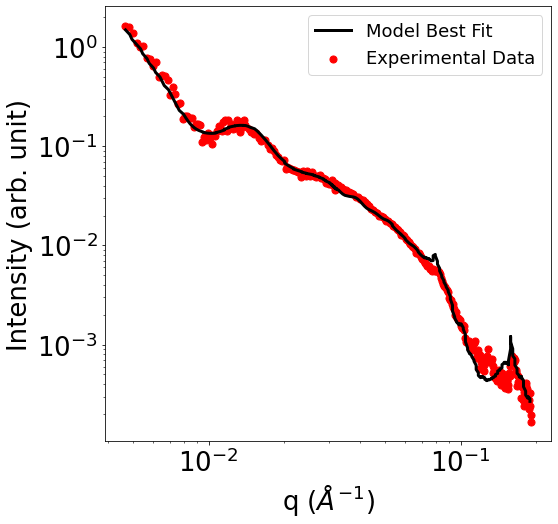

In [ ]:
plt.rcParams.update({'font.size': 26})
plt.subplots(figsize=(8,8))
plt.scatter(exp_data[:,0], exp_data[:,1], label = 'Experimental Data', s = 50, color = 'red')
#plt.scatter(q, exp_data, label = 'Experimental Data', s = 20, color = 'red')
plt.loglog(model_avg[:,0], model_avg[:,1], label = 'Model Best Fit', linewidth = 3, alpha = 1, color = 'k')
plt.legend(loc=1, prop={'size': 18})
plt.ylabel('Intensity (arb. unit)')
plt.xlabel('q ($\AA^{-1}$)')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('../Images/RhuA/best_fit.png', dpi=300, bbox_inches="tight")

Text(0.5, 0, 'Tube Outer Diameter (nm)')

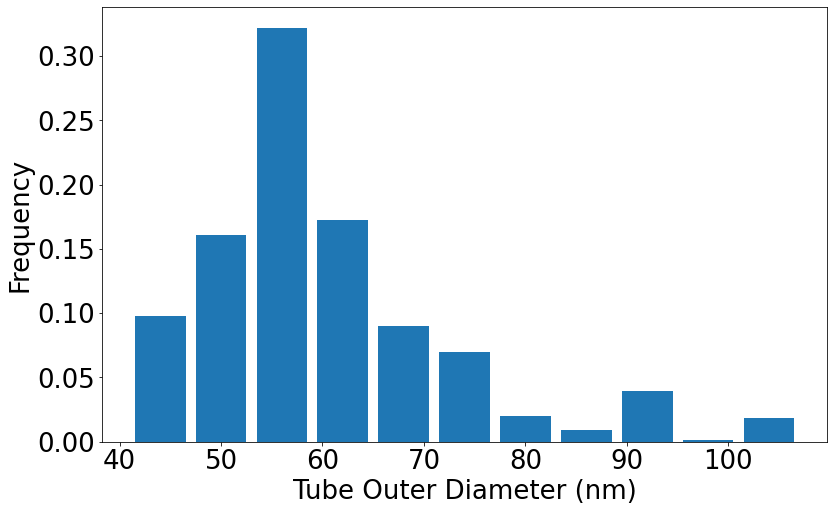

In [20]:
plt.subplots(figsize=(13,8))
plt.bar(hist_data[:,0], hist_data[:,1], width=5)
plt.ylabel('Frequency')
plt.xlabel('Tube Outer Diameter (nm)')
#plt.savefig('../Images/RhuA/best_fit_histogram.png', dpi=300, bbox_inches="tight")

Functions used to fit a normal distribution are created. 

In [21]:
def gaus(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def calculate_max_wv(sizes, spec, lower):
    peak_pos = find_peaks(spec, height=0.2)[0]
    upper = 8
    scaler = MinMaxScaler()
    coords = spec[int(np.round(peak_pos-lower)):int(np.round(peak_pos+upper))].reshape(-1,1)
    coords = scaler.fit(coords).transform(coords)
    new_wv = sizes[int(peak_pos-lower):int(peak_pos+upper)]
    
    angles = new_wv - np.mean(new_wv)
    data = coords
    angles = np.array(angles).flatten()
    data = np.array(data).flatten()

    n = len(data)  ## <---
    mean = np.sum(data*angles)/n
    sigma = np.sqrt(np.sum(data*(angles-mean)**2)/n)

    popt,pcov = curve_fit(gaus,angles,data)#,p0=[0.18,mean,sigma])  ## <--- leave out the first estimation of the parameters
    xx = np.linspace(np.min(angles), np.max(angles), 100)  ## <--- calculate against a continuous variable

    normal_fit = gaus(xx,*popt)
    xx_wv = xx + np.mean(new_wv)
    return xx_wv, normal_fit, popt

In [37]:
x_sizes, normal_fit, popt = calculate_max_wv(hist_data[:,0], hist_data[:,1], lower = 1)


x,y = np.histogram(em_data)
x_sizes_em, normal_fit_em, popt_em = calculate_max_wv(y[:-1], x, lower = 3)

x_,y_ = np.histogram(cryo_em_data)
x_sizes_cryo_em, normal_fit_cryo_em, popt_cryo_em = calculate_max_wv(y_, x_, lower = 2)

C:\Users\htchi\AppData\Local\Temp\ipykernel_19868\2485183179.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coords = spec[int(np.round(peak_pos-lower)):int(np.round(peak_pos+upper))].reshape(-1,1)
C:\Users\htchi\AppData\Local\Temp\ipykernel_19868\2485183179.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_wv = sizes[int(peak_pos-lower):int(peak_pos+upper)]
C:\Users\htchi\AppData\Local\Temp\ipykernel_19868\2485183179.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated

In [38]:
sizes = hist_data[:,0]
sizes_em = y

Text(40, -0.05, 'Tube Outer Diameter (nm)')

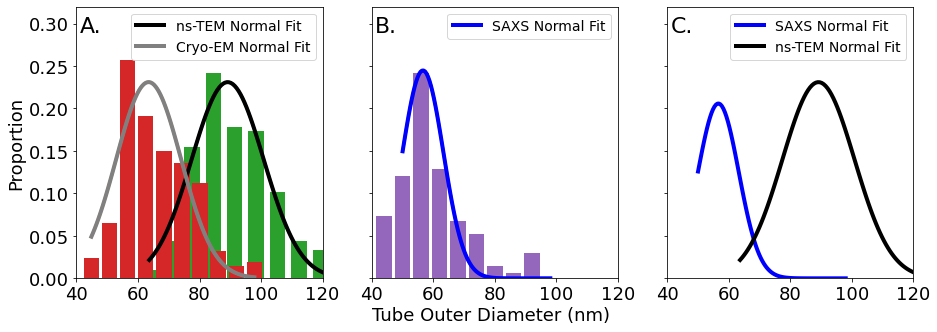

In [53]:
plt.rcParams.update({'font.size': 18})
x,y = np.histogram(em_data)
fig, ax = plt.subplots(figsize=(15, 5), ncols=3, nrows=1, sharey=True)
ax[0].bar(y[:-1], x/np.sum(x), width = 5, color='C2')
ax[0].plot(x_sizes_em, normal_fit_em/4, linewidth = 3)
ax[0].plot(x_sizes_em, normal_fit_em/4, linewidth = 4, color = 'black', label = 'ns-TEM Normal Fit')

ax[0].bar(y_[:-1], x_/np.sum(x_), width = 5, color='C3')
ax[0].plot(x_sizes_cryo_em, normal_fit_cryo_em/3.5, linewidth = 3)
ax[0].plot(x_sizes_cryo_em, normal_fit_cryo_em/3.5, linewidth = 4, color = 'gray', label = 'Cryo-EM Normal Fit')


ax[0].set_ylabel('Proportion')
ax[0].legend(loc = 1, fontsize = 14)
ax[0].set_ylim([0, 0.32])
ax[0].set_xlim([40, 120])


ax[1].bar(hist_data[:-1,0], hist_data[:-1,1]*0.75, width = 5, color = 'C4')
ax[1].plot(x_sizes, normal_fit/3.7, linewidth = 3)
ax[1].plot(x_sizes, normal_fit/3.7, linewidth = 4, color = 'blue', label = 'SAXS Normal Fit')
ax[1].legend(fontsize=14)
ax[1].set_xlim([40, 120])

ax[2].plot(x_sizes, normal_fit/4.4, linewidth = 4, color = 'blue', label = 'SAXS Normal Fit')
ax[2].plot(x_sizes_em, normal_fit_em/4, linewidth = 4, color = 'black', label = 'ns-TEM Normal Fit')
ax[2].legend(fontsize=14, loc=1)
ax[2].set_xlim([40, 120])

ax[0].text(41, 0.29, 'A.', fontsize=22)
ax[1].text(41, 0.29, 'B.', fontsize=22)
ax[2].text(41, 0.29, 'C.', fontsize=22)
ax[1].text(40, -0.05, 'Tube Outer Diameter (nm)')
#plt.savefig('../Images/RhuA/Histogram_Comparison.png', dpi=300, bbox_inches="tight")

(40.0, 120.0)

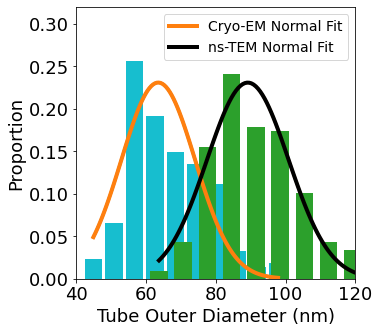

In [40]:
fig, ax = plt.subplots(figsize=(5, 5))


ax.bar(y_[:-1], x_/np.sum(x_), width = 5, color='C9')
ax.plot(x_sizes_cryo_em, normal_fit_cryo_em/3.5, linewidth = 3)
ax.plot(x_sizes_cryo_em, normal_fit_cryo_em/3.5, linewidth = 4, color = 'C1', label = 'Cryo-EM Normal Fit')


ax.bar(y[:-1], x/np.sum(x), width = 5, color='C2')
ax.set_ylim([0, 0.32])
ax.plot(x_sizes_em, normal_fit_em/4, linewidth = 3)
ax.plot(x_sizes_em, normal_fit_em/4, linewidth = 4, color = 'black', label = 'ns-TEM Normal Fit')



ax.set_ylabel('Proportion')
ax.legend(loc = 1, fontsize = 14)
ax.set_ylim([0, 0.32])
ax.set_xlabel('Tube Outer Diameter (nm)')
ax.set_xlim([40, 120])
#plt.savefig('../Images/RhuA/EM_histogram.png', dpi=600, bbox_inches="tight")

Text(0.5, 0, 'Tube Outer Diameter (nm)')

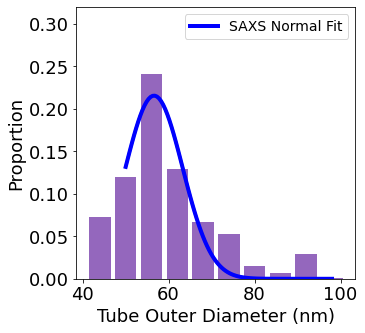

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(hist_data[:-1,0], hist_data[:-1,1]*0.75, width = 5, color = 'C4')
ax.plot(x_sizes, normal_fit/4.2, linewidth = 3)
ax.plot(x_sizes, normal_fit/4.2, linewidth = 4, color = 'blue', label = 'SAXS Normal Fit')
ax.legend(fontsize=14)
ax.legend(fontsize=14, loc=1)
ax.set_ylim([0, 0.32])
ax.set_ylabel('Proportion')
ax.set_xlabel('Tube Outer Diameter (nm)')
#plt.savefig('../Images/RhuA/SAXS_histogram.png', dpi=300, bbox_inches="tight")

Text(0.5, 0, 'Tube Outer Diameter (nm)')

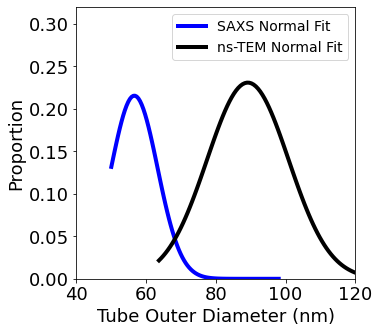

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_sizes, normal_fit/4.2, linewidth = 4, color = 'blue', label = 'SAXS Normal Fit')
ax.plot(x_sizes_em, normal_fit_em/4, linewidth = 4, color = 'black', label = 'ns-TEM Normal Fit')
ax.set_xlim([40,100])
ax.legend(fontsize=14, loc=1)
ax.set_ylim([0, 0.32])
ax.set_xlim([40, 120])
ax.set_ylabel('Proportion')
ax.set_xlabel('Tube Outer Diameter (nm)')
#plt.savefig('../Images/RhuA/SAXS__EM_histogram.png', dpi=300, bbox_inches="tight")

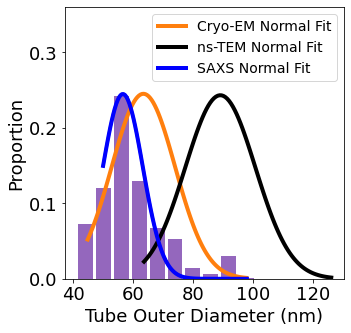

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(hist_data[:-1,0], hist_data[:-1,1]*0.75, width = 5, color = 'C4')


#ax.bar(y_[:-1], x_/np.sum(x_), width = 5, color='C3')
ax.plot(x_sizes_cryo_em, normal_fit_cryo_em/3.3, linewidth = 4, label = 'Cryo-EM Normal Fit', color = 'C1')

#ax.bar(y[:-1], x/np.sum(x), width = 5, color='C2')
ax.plot(x_sizes_em, normal_fit_em/3.8, linewidth = 4, color = 'black', label = 'ns-TEM Normal Fit')

ax.plot(x_sizes, normal_fit/3.7, linewidth = 3)
ax.plot(x_sizes, normal_fit/3.7, linewidth = 4, color = 'blue', label = 'SAXS Normal Fit')

ax.legend(fontsize=14)
ax.legend(fontsize=14, loc=1)
ax.set_ylim([0, 0.36])
ax.set_ylabel('Proportion')
ax.set_xlabel('Tube Outer Diameter (nm)')
#plt.savefig('../Images/RhuA/SAXS_histogram_all.png', dpi=600, bbox_inches="tight")

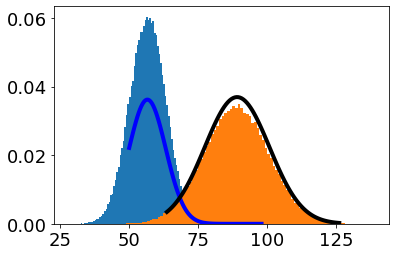

In [49]:
mean_saxs = x_sizes[np.argmax(normal_fit)]
mean_em = x_sizes_em[np.argmax(normal_fit_em)]
mean_cryo_em = x_sizes_cryo_em[np.argmax(normal_fit_cryo_em)]
normal_test = np.random.normal(mean_saxs, popt[-1], 100000)
normal_test_em = np.random.normal(mean_em, popt_em[-1], 100000)
plt.hist(normal_test, density=True, bins=100)
plt.hist(normal_test_em, density=True, bins=100)
plt.plot(x_sizes, normal_fit/25, linewidth = 4, color = 'blue', label = 'SAXS Normal Fit')
plt.plot(x_sizes_em, normal_fit_em/25, linewidth = 4, color = 'black', label = 'SAXS Normal Fit')

In [50]:
print('Mean SAXS: ', mean_saxs)
print('Mean EM: ', mean_em)
print('Mean cryo-EM: ', mean_cryo_em)
print('STD SAXS: ', popt[-1])
print('STD EM: ', popt_em[-1])
print('STD cryo-EM: ', popt_cryo_em[-1])

Mean SAXS:  56.78787878787879
Mean EM:  88.91790909090909
Mean cryo-EM:  63.57820899999999
STD SAXS:  6.649128572342319
STD EM:  11.701615621972643
STD cryo-EM:  10.565404687995606
